# Lab 2: Convolutional Neural Networks


Created for EIENDE9 - ECUE (Polytech Deep Learning course) by:

Gaetan Bahl - NXP Semiconductors - Vision TEC

gaetan.bahl@nxp.com / [LinkedIn](https://www.linkedin.com/in/gaetanbahl/)


---


In this second Lab, we discover a Deep Learning framework (Pytorch), which we use to create our very first CNN (LeNet) and use it to perform handwritten character recognition.

This Lab assumes that you are familiar with the Python language. If you're not, please do Lab 0 first: https://colab.research.google.com/drive/16XlCqmmUQvwBD3D5u0lOy1rUFfDDZdYi


# Introduction

## What's a CNN?

Convolutional Neural Networks are a subclass of Neural Networks that use Convolutional layers. These layers are basically sliding filters and work quite well for vision tasks.

![alt text](https://miro.medium.com/max/1838/1*p-_47puSuVNmRJnOXYPQCg.png)

## What's a framework and why are we using one (PyTorch)?

A programming framework is a collection of functions and utilities that is ready to use. Modern Deep Learning frameworks contain everything that is needed (layers, optimizers, losses, gradient computation...) to create and use neural networks, and make that really easy.

PyTorch, originally created by Facebook, is one of the most used frameworks, especially among researchers. The other most used framework are Tensorflow (created by Google) and Keras (an abstraction layer for multiple frameworks, including Tensorflow). PyTorch has gained a lot of popularity since its 1.0 release in 2018 and now surpassed Tensorflow.

## Why use Google Colab and GPUs?

Google Colab is a collaborative workspace based on Jupyter Notebook, that lets you use a Python environment on Google Cloud with GPUs, for FREE!

GPUs (Graphical Processing Units) are powerful chips that let you train and use neural networks much faster than CPUs. Having access to a GPU is very important for Deep Learning, as it can often make training more than 100x faster. It might not seem that huge at first, but state of the art neural nets can take days to train on common datasets, even with multiple powerful GPUs. On CPUs, it would take **years**.

Colab gives you access to a free Nvidia Tesla K80, P4, T4 or P100 GPU, which cost from 1000€ to 6000€ with 24GB, 8GB, 16GB or 16GB of VRAM, respectively.

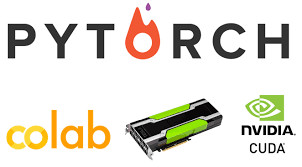

## /!\ IMPORTANT: Use a GPU Runtime

To use a GPU in Colab, go to Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU.

**Do this step before running any of the code below, otherwise you will have to run it again.**

# Checking that you have a GPU

Before going any further, let's check that we do have a GPU and which model we actually got. For this, we will use the **nvidia-smi** tool, which let's you monitor GPU usage, VRAM usage, temperature and fan speed.

Colab let's you run bash commands using a "!".

In [ ]:
!nvidia-smi

Wed Sep 25 14:27:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              26W /  70W |    153MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Importing libraries

For this lab, we only need PyTorch packages: "torch" and "torchvision".

"**torch**" contains the Deep Learning framework itself. "**torchvision**" contains datasets, pre-trained models, and image manipulation functions.

In [ ]:
#Import Pytorch
import torch
import torchvision

#Little commonly used shortcut
import torch.nn as nn

#We need the display function from IPython for Jupyter Notebook/Colab
from IPython.display import display

#A package to make beautiful progress bars :)
from tqdm.notebook import tqdm

## Downloading the data

We are working with the MNIST dataset, which containts handwritten digits.

We download the data using torchvision. We get the data in the form of a PyTorch "Dataset" object, which is a class that abstracts data loading and that can be iterated like a list.

In [ ]:
mnist_dataset = torchvision.datasets.MNIST(".", train=True, download=True)

print(mnist_dataset[1])

(<PIL.Image.Image image mode=L size=28x28 at 0x7E85D1152A70>, 0)


We see that each element is a tuple containing a PIL Image (Python Imaging Library) and a label (0 here).
We can visualize PIL images in Colab using the **display** function.

In [ ]:
display(mnist_dataset[128][0])

# Part 1: Looking at the data

In Data Science, it is very important to visualize the data we are working with, in order to understand it better and detect issues.

## Q1: Display 10 images with their label

Using a Python for loop and the **display** function, show 10 images from the dataset and their labels.

In [ ]:
for i in range(10):
  display(mnist_dataset[i][0])
  print(mnist_dataset[i][1])

5


0


4


1


9


2


1


3


1


4


## Q2: Display 10 images from a specific class

Using a Python "for" loop and conditions (or list comprehensions), display 10 images from a specific class (4, for example).

In [ ]:
count = 0
for image, label in mnist_dataset:
  if label == 4 and count < 10:
    display(image)
    print(label)
    count += 1

4


4


4


4


4


4


4


4


4


4


## Q3: Count the number of elements in each class

Using a "for" loop, the "count" method and the "print" function, display the number of elements in each class of the MNIST dataset.

In [ ]:
for i in range(10):
  print((mnist_dataset.targets == i).sum())

tensor(5923)
tensor(6742)
tensor(5958)
tensor(6131)
tensor(5842)
tensor(5421)
tensor(5918)
tensor(6265)
tensor(5851)
tensor(5949)


# Part 2: Creating a Neural Network with torch.nn

For our first CNN, we are going to implement LeNet5, which was used for handwritten digits classification for the first time in 1989 (http://yann.lecun.com/exdb/lenet/).

It is common to represent Neural Network architectures using charts such as this one:

![alt text](https://miro.medium.com/fit/c/1838/551/0*H9_eGAtkQXJXtkoK)




## Q4: Implementing the network

All networks created with torch.nn are subclasses of nn.Module.

To create our network, we need to define two methods: the init method ("\_\_init\_\_") and the **forward** propagation method.



*   In the "**init**" function, we define the **parts** (layers) of the network we are going to use and store them as attributes
*   In the "**forward**" function, we define the **order** of the layers by applying them to an input (define-by-run)




**Fill the code below** so that it corresponds to the architecture represented above. Please note that **there is a "ReLu" activation after every convolutional and linear (fully connected) layer in this architecture, that is not pictured.**

The torch.nn documentation will probably be useful https://pytorch.org/docs/stable/nn.html


In [ ]:
import torch
import torch.nn as nn

class MyFirstNetwork(nn.Module):

    def __init__(self):
        super(MyFirstNetwork, self).__init__()

        ## MNIST images are 28x28 but LeNet5 expects 32x32
        ## -> we pad the images with zeroes
        self.padding = nn.ZeroPad2d(2)

        ## First convolution
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)

        ## Second convolution
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        ## Pooling (subsampling) layer
        self.maxpool = nn.MaxPool2d(2)

        ## Activation layer
        self.relu = nn.ReLU()

        ## Fully connected layers
        self.fc1 = nn.Linear(in_features=400, out_features=120)  # 16 feature maps of size 5x5 after pooling
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.output = nn.Linear(in_features=84, out_features=10)

        ## Final activation layer
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        ## Pad the input
        x = self.padding(x)

        ## First convolution + activation
        x = self.conv1(x)
        x = self.relu(x)

        ## First pooling
        x = self.maxpool(x)

        ## Second Convolution + activation
        x = self.conv2(x)
        x = self.relu(x)

        ## 2nd pooling
        x = self.maxpool(x)

        ## "Flatten" the output to make it 1D
        x = x.view(-1, 16 * 5 * 5)  # 16 channels of 5x5 feature maps

        ## First full connection + activation
        x = self.fc1(x)
        x = self.relu(x)

        ## Second full connection + activation
        x = self.fc2(x)
        x = self.relu(x)

        ## Output layer
        x = self.output(x)
        y = self.softmax(x)

        return y

import torchsummary
net = MyFirstNetwork().cuda()
torchsummary.summary(net, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1            [-1, 1, 32, 32]               0
            Conv2d-2            [-1, 6, 28, 28]             156
              ReLU-3            [-1, 6, 28, 28]               0
         MaxPool2d-4            [-1, 6, 14, 14]               0
            Conv2d-5           [-1, 16, 10, 10]           2,416
              ReLU-6           [-1, 16, 10, 10]               0
         MaxPool2d-7             [-1, 16, 5, 5]               0
            Linear-8                  [-1, 120]          48,120
              ReLU-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             ReLU-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
       LogSoftmax-13                   [-1, 10]               0
Total params: 61,706
Trainable params: 

### Testing our implementation

To check that the network is working and possibly correct mistakes, we apply the forward method to an image from the MNIST dataset.

**Check that your network is working by running the code below.**

At any point in the forward pass, you can execute Python code allowing you to debug the network. This is one of the main benefits of using PyTorch. This framework has "eager execution", and the architecture is "defined-by-run". Other frameworks, such as Tensorflow, compile the network into a fixed graph that cannot be debugged using prints.

PyTorch works on objects called **Tensors**, which are N-dimensional matrices.

Tensors can be displayed using the Python '**print**' function, their size can be accessed using **x.size()**, etc.

See the PyTorch documentation for other operations on Tensors https://pytorch.org/docs/stable/tensors.html


In [ ]:
## Create an instance of our network
net = MyFirstNetwork()

## Create a conversion function to convert PIL images into Tensors
convert = torchvision.transforms.ToTensor()

## Get our input image as a tensor. We add a dimension with "unsqueeze", because
## PyTorch is used to working with batches.
x = convert(mnist_dataset[0][0]).unsqueeze(0)

## Apply the network to the input
net(x)

tensor([[-2.4001, -2.2234, -2.3138, -2.3062, -2.3292, -2.3367, -2.2451, -2.2122,
         -2.2905, -2.3870]], grad_fn=<LogSoftmaxBackward0>)

The result should be a 10-dimensional vector (tensor) of probabilities. If your network does not work, edit it and try again!

NOTE: You can notice a "LogSoftmaxBackward" object. PyTorch automatically tracks which operations have been performed on Tensors, so that it can perform automatic gradient computation during training.

#  Part 3: Training the network



## Choosing a loss function and an optimizer

As a Loss, the negative log likelihood (also called cross-entropy) is well suited here, because we have an N-class classification problem.

Stochastic Gradient Descent is the most basic optimization algorithm. You can try to use another one from torch.optim (https://pytorch.org/docs/stable/optim.html). You can also try to adjust the learning rate (lr parameter).

In [ ]:
# Negative log likelihood loss
criterion = nn.NLLLoss()

# Stochastic Gradient Descent
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

## Basic training bricks

There are 4 parts to train the network on one sample of the dataset:



1.   Compute the forward pass

```
    y = net(x)
```


2.   Compute the loss


```
    loss = criterion(y, label)
```


3.   Reset the gradients


```
    optimizer.zero_grad()
```


4.   Compute the backward pass



```
     loss.backward()

```



5.   Apply one optimization step



```
     optimizer.step()

```





## Q5: Creating a basic training loop

Neural Networks are trained using training loops. We go over the dataset multiple times (each time is called an "epoch"), using "batches" of data.

First, we are going to create the most basic training loop possible, going over the dataset manually using a batch size of 1 (the network sees the images one by one). Every time an image goes through the network, we compute the loss and the gradients and update the network weights.

**Fill the code below using the basic training bricks above to create the training loop.**

In [ ]:
## MODIFY THIS LINE IF THE TRAINING TAKES TOO LONG (MAX 60000)
SAMPLES_TO_USE = 2000

## NUMBER OF EPOCHS TO TRAIN
N_EPOCHS = 8

## Put the network in training mode
net.train()

## Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

for e in tqdm(range(N_EPOCHS), desc='Epochs'):

  running_loss = 0
  running_accuracy = 0

  for i in tqdm(range(SAMPLES_TO_USE), desc="Samples"):

    # Get a sample from the dataset
    sample = mnist_dataset[i]
    x = convert(sample[0]).unsqueeze(0)  # Input image tensor
    label = torch.tensor([sample[1]])  # Corresponding label

    # Zero the parameter gradients
    optimizer.zero_grad()

    ## Forward pass: compute network output
    y = net(x)

    ## Compute the loss
    loss = criterion(y, label)

    ## Backward pass: compute gradients
    loss.backward()

    ## Update network weights
    optimizer.step()

    ## Compute some statistics
    with torch.no_grad():
      running_loss += loss.item()  # Add current loss to running loss
      running_accuracy += 1 if y.argmax(1) == label else 0  # Update accuracy count

  print(f"Training accuracy after epoch {e+1}: {running_accuracy/SAMPLES_TO_USE}")
  print(f"Training loss after epoch {e+1}: {running_loss/SAMPLES_TO_USE}")


Epochs:   0%|          | 0/8 [00:00<?, ?it/s]

Samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Training accuracy after epoch 1: 0.395
Training loss after epoch 1: 1.6907217703951174


Samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Training accuracy after epoch 2: 0.8735
Training loss after epoch 2: 0.3932413166988733


Samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Training accuracy after epoch 3: 0.9375
Training loss after epoch 3: 0.21483337666652041


Samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Training accuracy after epoch 4: 0.953
Training loss after epoch 4: 0.14478504799821668


Samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Training accuracy after epoch 5: 0.97
Training loss after epoch 5: 0.110809091885911


Samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Training accuracy after epoch 6: 0.976
Training loss after epoch 6: 0.07519900856737756


Samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Training accuracy after epoch 7: 0.9735
Training loss after epoch 7: 0.09298166652604611


Samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Training accuracy after epoch 8: 0.976
Training loss after epoch 8: 0.08168075794954273


## Evaluating on a test set

While performance on the training set might be good (you can reach 100% accuracy in this example), what really matters is performance on the test set. The test set is composed of images the network has never seen before.

**Run the following code to evaluate your network.** Make sure that you reach at least approximately 90% test accuracy before moving on to the next part!

In [ ]:
#Get the MNIST test set
mnist_test_dataset = torchvision.datasets.MNIST(".", train=False, transform=convert, download=True)

print("Number of test images:", len(mnist_test_dataset))

#Put the network in eval mode
net.eval()

acc = 0
#Disable gradient computation for this (we do not need them, this will speed up testing)
with torch.no_grad():
  for img, label in tqdm(mnist_test_dataset):

    y = net(img.unsqueeze(0))

    if y.max(1)[1] == label:
      acc +=1

  print("Test Accuracy:", acc/len(mnist_test_dataset))


Number of test images: 10000


  0%|          | 0/10000 [00:00<?, ?it/s]

Test Accuracy: 0.9496


## Q6: Displaying a few random results from the test set

Let's look at some results, to visualize in which cases our network makes mistakes.

Using Python's **random** package and your trained neural network, display 10 results from the test set.

HINT: to get the network output for a sample as a number, you can use:

```
    net(convert(sample[0]).unsqueeze(0)).max(1)[1]
```



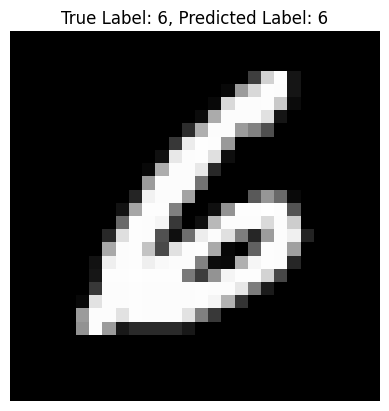

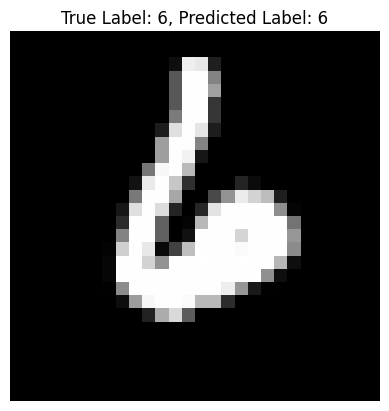

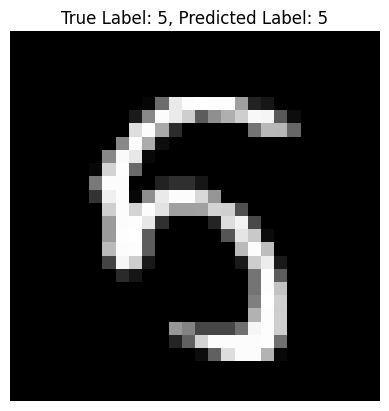

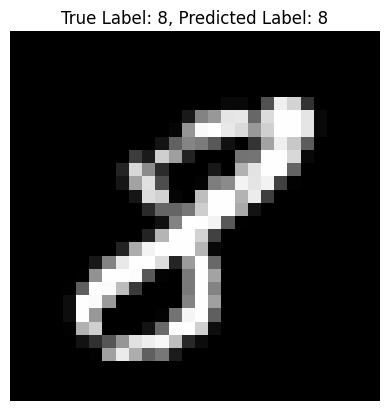

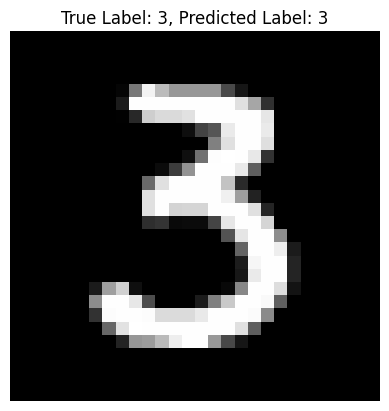

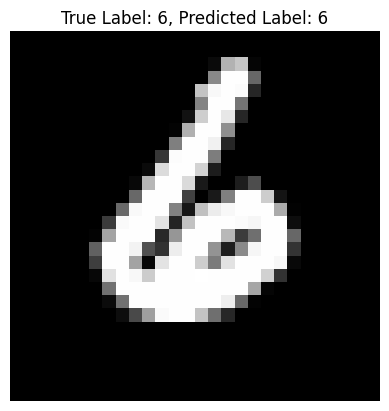

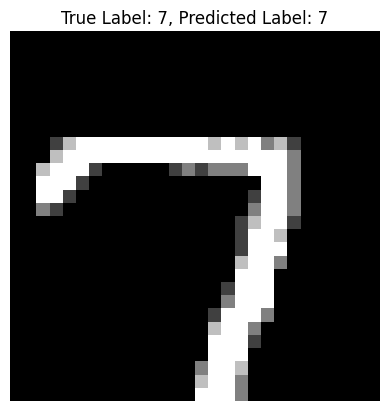

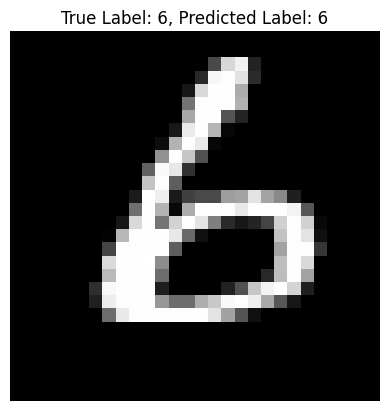

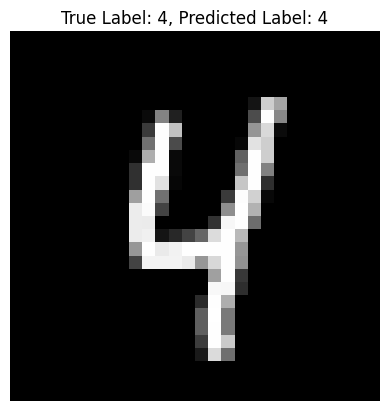

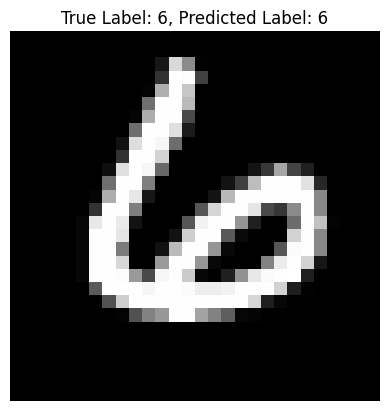

In [ ]:
import random
import matplotlib.pyplot as plt

# Get the MNIST test set in PIL format (non-tensor format)
mnist_test_dataset_PIL = torchvision.datasets.MNIST(".", train=False, download=True)

net.eval()

# Disable gradient computation as it is not needed during evaluation
with torch.no_grad():
    for i in range(10):
        # Pick a random sample index from the test set
        idx = random.randint(0, len(mnist_test_dataset_PIL) - 1)

        # Get the image (PIL format) and label
        sample = mnist_test_dataset_PIL[idx]
        img, true_label = sample

        # Convert the image to the correct format for the network
        input_img = convert(img).unsqueeze(0)

        # Get the network's predicted label
        predicted_label = net(input_img).max(1)[1].item()

        # Plot the image using matplotlib
        plt.imshow(img, cmap='gray')
        plt.title(f"True Label: {true_label}, Predicted Label: {predicted_label}")
        plt.axis('off')
        plt.show()


# Part 4: Creating a better training loop

Our basic training method works, but as you might have noticed it is pretty slow.
In this section, we improve it to create a "good" PyTorch training loop, by using batches, data loaders, validation data, and GPUs.

## Splitting between validation and training data

It is common to split the training dataset into a training set and a validation set.

The network is trained on the training set, and its performance is validated at each epoch using the validation set.

This is used to prevent overfitting. If the training accuracy/loss improves but the validation accuracy/loss stagnate or worsen we are **overfitting** the training set.

The final evaluation is still done on the test set.

![Texte alternatif…](https://miro.medium.com/max/1552/1*Nv2NNALuokZEcV6hYEHdGA.png)

This is very easy in PyTorch. Let's split our MNIST **Dataset** into two random **Subsets** (it's a subclass of **Dataset**).

In [ ]:
## Load Dataset
mnist_dataset = torchvision.datasets.MNIST(".", train=True, transform=convert, download=True)

## Percentage of validation data
validation_split = 0.1

N_val_samples = round(validation_split * len(mnist_dataset))

## Split into two Subset
train_set, val_set = torch.utils.data.random_split(mnist_dataset, [len(mnist_dataset) - N_val_samples, N_val_samples])

# train and val are Subset objects
print(train_set)
print(val_set)

# Their sizes should be correct
len(train_set) + len(val_set) == len(mnist_dataset)

True

## DataLoaders in PyTorch

In PyTorch, **DataLoaders** are tools that load **batches** of data from a **Dataset** (or any of its subclasses).

Training in batches of multiple samples (8, 32, 512...) can be a lot faster thanks to parallelism. Also, it helps with gradient descent by averaging the gradient over the whole batch.

Documentation on DataLoaders is here: https://pytorch.org/docs/stable/data.html

In [ ]:
import torch
from torch.utils.data import DataLoader

# Set the batch size
BATCH_SIZE = 64

# Create a DataLoader for the training set
# num_workers = number of CPU cores
mnist_train_dl = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Q7: Use the DataLoaders

Using the DataLoader we just created, **print the number of batches it contains (you should see len(train_set)/batch_size), and print a batch from the dataset.**

HINT: you can get a Python iterator from a DataLoader using the **iter** function, because a DataLoader is an **iterable** object. https://wiki.python.org/moin/Iterator

You should see a number of samples and labels equal to your batch size.

In [ ]:
## Print the length of the dataloader

print(len(mnist_train_dl))

## Print a batch

batch = next(iter(mnist_train_dl))
print(batch[0].shape)
print(batch[1])

844


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([64, 1, 28, 28])
tensor([9, 0, 6, 5, 3, 4, 1, 9, 0, 5, 2, 1, 1, 5, 9, 2, 6, 9, 8, 2, 1, 9, 7, 4,
        6, 4, 1, 6, 4, 5, 9, 8, 3, 1, 4, 2, 3, 3, 9, 0, 4, 7, 8, 2, 0, 0, 7, 7,
        8, 0, 4, 2, 5, 7, 1, 6, 8, 5, 1, 6, 0, 8, 5, 5])


## Q8: Create a DataLoader for the validation set

In the same way, **create a DataLoader for the validation set**.

In [ ]:
mnist_val_dl = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

batch_val = next(iter(mnist_val_dl))

print(batch_val[0].shape)
print(batch_val[1])

torch.Size([64, 1, 28, 28])
tensor([5, 7, 7, 9, 1, 3, 0, 4, 9, 8, 6, 9, 6, 1, 7, 4, 9, 8, 2, 3, 4, 4, 3, 1,
        3, 9, 7, 8, 9, 2, 0, 6, 5, 8, 6, 0, 9, 3, 1, 2, 6, 4, 5, 1, 8, 1, 7, 4,
        7, 2, 1, 3, 3, 9, 3, 9, 4, 1, 9, 3, 5, 6, 7, 5])


## Using a GPU

Using a GPU in PyTorch is very easy and will make our training A LOT faster.

To perform calculations on a batch on the GPU, our batch has to be moved to the GPU.

To move a Tensor to the GPU memory, use the **cuda()** method.

If you do not have a GPU, you will get a cuda runtime error. To add a GPU to Colab, go to Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU.

In [ ]:
batch = torch.Tensor(next(iter(mnist_train_dl))[0])

batch = batch.cuda()

print(batch)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

You can see "device='cuda:0'", which means our Tensor has been moved to the first GPU in the system!

Now, we also need to move our neural network to the GPU, because the computations between the network weights and the training data will happen on the GPU.

For this, we also use the **cuda()** method.

In [ ]:
## Create an instance of our network
net = MyFirstNetwork()

## Move it to the GPU
net = net.cuda()

Let's test this by computing an output on the GPU.

In [ ]:
output = net(batch)

print(output)

tensor([[-2.2029, -2.2985, -2.3356, -2.3300, -2.2960, -2.3597, -2.2915, -2.3725,
         -2.3960, -2.1672],
        [-2.2033, -2.3027, -2.3369, -2.3309, -2.2921, -2.3655, -2.2884, -2.3682,
         -2.3937, -2.1679],
        [-2.2008, -2.2986, -2.3438, -2.3223, -2.2940, -2.3661, -2.2866, -2.3728,
         -2.3888, -2.1752],
        [-2.2034, -2.2985, -2.3402, -2.3224, -2.2921, -2.3648, -2.2874, -2.3714,
         -2.3892, -2.1784],
        [-2.2036, -2.2992, -2.3366, -2.3263, -2.2922, -2.3609, -2.2923, -2.3715,
         -2.3981, -2.1689],
        [-2.2017, -2.2994, -2.3408, -2.3267, -2.2928, -2.3630, -2.2904, -2.3671,
         -2.3944, -2.1726],
        [-2.1979, -2.3022, -2.3415, -2.3275, -2.2933, -2.3639, -2.2949, -2.3695,
         -2.3873, -2.1712],
        [-2.2001, -2.3028, -2.3382, -2.3321, -2.2922, -2.3584, -2.2895, -2.3713,
         -2.3903, -2.1738],
        [-2.2011, -2.3055, -2.3432, -2.3246, -2.2904, -2.3619, -2.2864, -2.3658,
         -2.4003, -2.1707],
        [-2.1997, -

## Q9: Our new training/validation loop

Now, we have all the necessary bricks to build our new improved training/validation loop!

We have already written the training loop for you. Complete the validation loop!

You should see that your network trains very fast on the whole training set now. One epoch should take about 10 seconds, depending on your batch size, compared to about 3 minutes on the CPU.

In [ ]:
##RE-RUN THIS CODE TO GET A "NEW" NETWORK

LEARNING_RATE = 0.001
MOMENTUM = 0

## Create an instance of our network
net = MyFirstNetwork()

## Move it to the GPU
net = net.cuda()

# Negative log likelihood loss
criterion = nn.NLLLoss()

# Stochastic Gradient Descent
optimizer = torch.optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

In [ ]:
tqdm_notebook = tqdm

## NUMBER OF EPOCHS TO TRAIN
N_EPOCHS = 20

epoch_loss, epoch_acc, epoch_val_loss, epoch_val_acc = [], [], [], []

for e in tqdm_notebook(range(N_EPOCHS), desc='Epochs'):


  ### TRAINING LOOP
  running_loss = 0
  running_accuracy = 0

  ## Put the network in training mode
  net.train()

  for i, batch in enumerate(tqdm_notebook(mnist_train_dl, desc="Training Batches")):

    # Get a batch from the dataloader
    x = batch[0]
    labels = batch[1]

    # move the batch to GPU
    x = x.cuda()
    labels = labels.cuda()

    # Compute the network output
    y = net(x)

    # Compute the loss
    loss = criterion(y, labels)

    # Reset the gradients
    optimizer.zero_grad()

    # Compute the gradients
    loss.backward()

    # Apply one step of the descent algorithm to update the weights
    optimizer.step()

    ## Compute some statistics
    with torch.no_grad():
      running_loss += loss.item()
      running_accuracy += (y.max(1)[1] == labels).sum().item()

  print("Training accuracy:", running_accuracy/float(len(train_set)),
        "Training loss:", running_loss/float(len(train_set)))

  epoch_loss.append(running_loss/len(train_set))
  epoch_acc.append(running_accuracy/len(train_set))

  ### VALIDATION LOOP
  ## Put the network in validation mode
  net.eval()

  running_val_loss = 0
  running_val_accuracy = 0

  for i, batch in enumerate(tqdm_notebook(mnist_val_dl, desc="Validation Batches")):

    # Get a batch from the dataloader
    x = batch[0]
    labels = batch[1]

    # move the batch to GPU
    x = x.cuda()
    labels = labels.cuda()

    # Compute the network output
    y = net(x)

    ## Compute some statistics
    with torch.no_grad():
      running_loss += loss.item()
      running_accuracy += (y.max(1)[1] == labels).sum().item()

  epoch_val_loss.append(running_loss/len(val_set))
  epoch_val_acc.append(running_accuracy/len(val_set))

  print("Val accuracy:", running_accuracy/float(len(val_set)),
        "Val loss:", running_loss/float(len(val_set)))


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/844 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training accuracy: 0.899537037037037 Training loss: 0.005177561181838866


Validation Batches:   0%|          | 0/94 [00:00<?, ?it/s]

Val accuracy: 8.997666666666667 Val loss: 0.05032573619236549


Training Batches:   0%|          | 0/844 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Q10: Making a graph with training/validation accuracy and loss

You can visualize your losses and accuracies over time using matplotlib.

Modify the training/val loop above to store the values (in a list), and display them in a graph.

Can you spot the moment where we start to overfit the training set?

Try adjusting the number of epochs, the batch size, the learning rate or changing the optimizer (add some momentum or try Adam) to get a better result on the validation set.

Optimizers documentation: https://pytorch.org/docs/stable/optim.html#algorithms

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

### YOUR CODE HERE


## Q11: Evaluate our network on the test set (on GPU)

In the same way you wrote the validation loop, create a DataLoader on the mnist test dataset, and write a test loop!

You should be able to get 90% accuracy on the test set :)


In [ ]:
#Get the MNIST test set
mnist_test_dataset = torchvision.datasets.MNIST(".", train=False, transform=convert, download=True)

### WRITE THE TEST LOOP (HINT: it looks a lot like the validation loop)

# (OPTIONAL) Part 5: Cats vs Dogs with a torchvision network

To test our skills on a new dataset, we will work on the famous Dogs vs Cats Kaggle dataset.

![cats dogs dataset sample images](https://storage.googleapis.com/tfds-data/visualization/fig/cats_vs_dogs-4.0.0.png)


Kaggle is a website that hosts machine learning/data science competitions. Check it out! https://www.kaggle.com/

![kaggle logo](https://miro.medium.com/max/668/1*GZrTyTz0OKMbxnO5Trhcew.png)

## Downloading the data

First, go to the Kaggle website and create an account.

Then go to your account, click on Create New API Token - It will download kaggle.json file on your machine.

Upload the kaggle.json file using this code:




In [ ]:
! pip install -q kaggle

from google.colab import files

files.upload()

Download the dogs vs cats dataset using this code:

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c dogs-vs-cats

Extract the archives:

In [ ]:
! rm -rf test1 train

! unzip -q train.zip

! unzip -q test1.zip

Put the data in separate directories:

In [ ]:
! mkdir train/cats
! mkdir train/dogs
! mv train/cat.* train/cats
! mv train/dog.* train/dogs

## Q12: Load the data

Using ImageFolder from torchvision (https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder), load the dataset.

The training set is in the "train" directory.

In [ ]:
### YOUR CODE HERE

## Q13: Display a few images

As before, display a few images with the **display** function. You can see that these images have varying sizes.

In [ ]:
### YOUR CODE HERE

## Using a torchvision model

torchvision has a repository of popular models ready to use for diverse computer vision tasks (classification, segmentation,...)

https://pytorch.org/docs/stable/torchvision/models.html#classification



In [ ]:
## You can change the model if you want
net = torchvision.models.resnet18()

print(net)

## torchvision models are meant to be used on imagenet (1000 classes)
## since we only have two classes, we need to modify the last layer

net.fc = nn.Linear(512,2)

## Q14: Resize the images on the fly using torchvision transforms

We can see from the documentation that torchvision models expect at least 244x244 images.

1. Using torchvision.transforms, create a new ImageFolder dataset with on-the-fly resizing of images.

2. Split this Dataset into training and validation sets, as before.

3. Create a DataLoader for each set as well, just like before.

In [ ]:
### YOUR CODE HERE

## Q15: Training the model

Write the training loop. You should be able to pretty much copy-paste the one from Q9.

In [ ]:
LEARNING_RATE = 0.001

## Move model to the GPU
net = net.cuda()

# Negative log likelihood loss
criterion = nn.NLLLoss()

# Stochastic Gradient Descent
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [ ]:
### YOUR CODE HERE

## Q16: Test the network

Compute some predictions on the test set.

In [ ]:
### YOUR CODE HERE

## Q17: Going further

Try different networks from torchvision, and different parameters. The winner of the competition got more than 98% accuracy. How much can you get?

Data augmentation (modifying your input data to make "more" of it) is a huge thing in deep learning. Try some techniques such as random cropping and rotation using torchvision transforms in your Dataset objects!

PyTorch has a lot of tutorials to get you started: https://pytorch.org/tutorials/index.html

Have fun!

